In [ ]:
#!pip install plotly
#!pip install keras
#!pip install tensorflow
import numpy as np
import pandas as pd
import csv
import random
import statistics as st
from collections import Counter
from sklearn import svm
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import keras
from sklearn.externals import joblib
from keras.models import Sequential
from keras.layers import Dense 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import KFold
from keras.preprocessing import sequence
np.random.seed(3)
from sklearn.metrics import confusion_matrix
import itertools
import pickle



In [2]:
def createTrainTest(DataSet):
    #replace the missing Values
    #replacement with most occurent class
    #Mode = st.mode(DataSet.Emotion.dropna())
    #DataSet.Emotion.fillna(Mode,inplace = True)
    DataSet.dropna( inplace = True)
    #Create TRAIN VAL en TEST but first randomize data
    indexesDS = pd.DataFrame({'i':range(1,len(DataSet),1)})
    indexesR = indexesDS.sample(frac = 1)
    #TRAIN = 75%
    iTrain = indexesR[1:round(0.75 * len(DataSet))]
    TRAINset = DataSet.iloc[iTrain.iloc[:,0]]
    TRAIN = TRAINset.iloc[:,0:(len(DataSet.columns)-1)]
    yTrain = TRAINset.iloc[:,-1]
    #VAL = 20%
    #iVal = indexesR[round(0.6 * len(DataSet)):round(0.8 * len(DataSet))]
    #VAL = DataSet.loc[iVal.iloc[:,0]]
    #TEST = 25%
    iTest = indexesR[round(0.75 * len(DataSet)):len(DataSet)]
    TESTset = DataSet.iloc[iTest.iloc[:,0]]
    TEST = TESTset.iloc[:,0:(len(DataSet.columns)-1)]
    yTest= TESTset.iloc[:,-1]
    return TRAIN,TEST,yTrain,yTest

Try-out one: One vs. Rest classifier with Linear SVC --> moeten wij geen Gaussian kernel gebruiken? 
- andere opties: Logistic Regression
- neural network (enige nadeel is snelheid, maar meer aangeraden, zeker naast SVM zetten

In [3]:
#the algorithm is calculated with K-fold cross calculation
#In the end the average accuracy is taken to evaluate the model

def CalcLinearKernel(k,df,yDf,C,gamma):
    AccuracyArray = []
    coefficients = []
    for i in range(1,(k+1)): 
        #obtain min index to divide train and val
        Min = round((len(df)/k)*(i-1)+1)
        #obtain  max index to divide train and val
        Max = round((len(df)/k*i))
        #create a val and train set to create the model
        val = df[Min : Max]
        yval = yDf[Min : Max]
        train = df.drop(df.index[Min:Max])
        ytrain = yDf.drop(yDf.index[Min:Max])
       
        #create a model
        ##C  = 1 is default, however to optimize model, should iterate over c to use the best model
        ###C can vary from 0.1 to 10(0) with steps of 0.1
        ##we have more than one label class, therefore one vs Rest  --> ovr
        ##now linear kernel, however a Gaussian one would be better
        ##Hinge loss function
        model = svm.SVC(kernel = 'rbf',C = C,gamma = gamma, decision_function_shape = 'ovr', verbose= True)#radial based function
        model.fit(train, ytrain)
        #predict
        ValPred = model.predict(val)
        n = len(val)
        #calculate the accuracy and append it to the accuracies of the other folds
        FALSE = Counter(yval == ValPred)[0]
        TRUE = Counter(yval == ValPred)[1]
        Accuracy = TRUE/n
        AccuracyArray.append(Accuracy)
    Accuracy = np.mean(AccuracyArray)
    
    return Accuracy

In [4]:
def TrainPredictLinearKernel(k,TRAIN,yTrain,TEST,yTest,CMax):
    Accuracy = []
    #Optimize C
    AccuracyArray = []
    coefficients = []
    #c = np.logspace(-2, 10, 13)
    c = np.logspace(-3, 2, 6)
    #gamma = np.logspace(-9, 3, 13)
    gamma = np.logspace(-3, 2, 6)
    for n in c: ## C
        print(n)
        SubAccuracy = []
        for m in gamma:
            print(m)
            SubAccuracyG = CalcLinearKernel(k,TRAIN,yTrain,C=n,gamma=m)
            SubAccuracy.append(SubAccuracyG)
        AccuracyArray.append(SubAccuracy)
    print(c[AccuracyArray.index(max(AccuracyArray))])

    C = c[AccuracyArray.index(max(AccuracyArray))]
    gamma = gamma[AccuracyArray[AccuracyArray.index(max(AccuracyArray))].index(max(SubAccuracy))]
    
    model = svm.SVC(kernel = 'rbf', C = C,gamma = gamma, decision_function_shape = 'ovr', verbose = True)
    model.fit(TRAIN,yTrain)
    Predict = model.predict(TEST)
    n = len(TEST)
    #calculate the accuracy and append it to the accuracies of the other folds
    FALSE = Counter(yTest == Predict)[0]
    TRUE = Counter(yTest == Predict)[1]
    TestAcc = TRUE/n
    #Temp = TEST
    #Temp["PredictedYvar"] = Predict
    #PredictedBasetable = Temp
    #print(Test)
    return Predict,TestAcc,model

Try out 2: Neural Networks

In [5]:
def TrainNN(TRAIN,yTrain,TEST,yTest,k):
    #convert string classes to integers
    classes = yTrain.unique()
    NrClasses = len(yTrain.unique())
    ConvertClass = dict()
    for i in range(NrClasses):
        ConvertClass[classes[i]] = i
    yTrainNum = yTrain.replace(ConvertClass,regex = True)
    yTestNum = yTest.replace(ConvertClass, regex = True)


    #convert output to one-hot
    y_train = keras.utils.to_categorical(yTrainNum, NrClasses)#de y var moet naar 5 verschillende classen(cijfers) omgezet worden
    y_test = keras.utils.to_categorical(yTestNum, NrClasses)
    print("final model is created")
    #create final model 
    model = Sequential()
    model.add(Dense(100, input_dim=300, activation='relu'))#output dim = 100
    model.add(Dense(50, activation='relu'))
    model.add(Dense(NrClasses, activation='softmax'))
    
    # compile and fit final model
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.fit(TRAIN, y_train, batch_size=15, epochs=150)#, validation_data=(TEST, y_test))
    classesT = model.predict(TEST,batch_size = 15)
    #convert the predicted probabilities to binary variables, since we want to compare to yval
    for j in range(len(classesT)):
        classesT[j][classesT[j] == classesT[j].max()] = 1
        classesT[j][classesT[j] != classesT[j].max()] = 0 
    arrayT = (y_test == classesT)

    #count the number of false predicted records
    counter = 0
    for z in range(len(arrayT)):
                    if False in arrayT[z]:
                        counter +=1 
    #switch key and value, in order to map words wuth columnindex                
    bDict = {val:key for (key, val) in ConvertClass.items()}
    yDF = pd.DataFrame(classesT)
    y = yDF.apply(lambda x: int(np.argmax(x)), axis=1)
    print(y)
    y = y.replace(bDict,regex = True)
    
    #calculate the accuracy and store it in an array
    Acc = (len(arrayT) - counter)/len(arrayT)
    #Temp = TEST
    #Temp["Emotion"] = y
    #PredictedBasetable = Temp
    return y,Acc,model

Logistic regression with one vs all mechanism and Cross-Validation

In [6]:
def TrainLogRegression(TRAIN,yTrain, TEST,yTest,k):
    #create the folds for the corss-validation
    fold = KFold(len(yTrain), n_folds=5, shuffle=True, random_state=777)
    searchCV = LogisticRegressionCV(
    Cs=list(np.power(10.0, np.arange(-10, 10)))
    ,penalty='l2'#geldt voor feature selection
    ,cv=fold
    ,scoring = 'accuracy'
    ,max_iter=10000
    ,fit_intercept=True
    ,solver='newton-cg'
    ,tol=10
    ,multi_class = 'ovr'
    )
    searchCV.fit(TRAIN, yTrain)
    Predicted = searchCV.predict(TEST)
    Acc = searchCV.score(Test,ytest)#mean accuracy
    return Predicted,Acc,searchCV
    

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [32]:

folder = "/Users/hovensa/OneDrive - delaware/Data science/WK/"
language = 'fr'
df = pd.read_csv(folder + "WKDataset " + language + ".csv", delimiter = ';')
#we do not want to have the first column, since this is an index
DataSet = df.iloc[:,1:len(df.columns)]
Train,Test,ytrain,ytest = createTrainTest(DataSet)


In [9]:
PredNlSVM,AccNlSVM,ModelNlSVM = TrainPredictLinearKernel(5,Train,ytrain,Test,ytest,10)

0.001
0.001
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.01
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.1
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]1.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]10.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]100.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.01
0.001
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.01
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.1
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]1.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]10.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]100.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.1
0.001
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.01
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.1
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]1.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]10.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]100.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]1.0
0.001
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.01
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.1
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]1.0
[LibSVM][LibSVM][LibSVM][LibSVM]

In [16]:
PredFrSVM,AccFrSVM,ModelFrSVM = TrainPredictLinearKernel(5,Train,ytrain,Test,ytest,10)

0.001
0.001
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.01
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.1
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]1.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]10.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]100.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.01
0.001
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.01
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.1
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]1.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]10.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]100.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.1
0.001
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.01
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.1
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]1.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]10.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]100.0
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]1.0
0.001
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.01
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.1
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]1.0
[LibSVM][LibSVM][LibSVM][LibSVM]

In [20]:
PredNlNN,AccNlNN,ModelNlNN = TrainNN(Train,ytrain,Test,ytest,5)

final model is created
Epoch 1/150
2849/2849 [==============================] - 1s 300us/step - loss: 1.2456 - acc: 0.5142
Epoch 2/150
2849/2849 [==============================] - 0s 129us/step - loss: 0.9630 - acc: 0.6479
Epoch 3/150
2849/2849 [==============================] - 0s 166us/step - loss: 0.7793 - acc: 0.7262
Epoch 4/150
2849/2849 [==============================] - 0s 160us/step - loss: 0.6394 - acc: 0.7855
Epoch 5/150
2849/2849 [==============================] - 0s 139us/step - loss: 0.5270 - acc: 0.8245
Epoch 6/150
2849/2849 [==============================] - 0s 154us/step - loss: 0.4370 - acc: 0.8575
Epoch 7/150
2849/2849 [==============================] - 0s 124us/step - loss: 0.3641 - acc: 0.8866
Epoch 8/150
2849/2849 [==============================] - 0s 143us/step - loss: 0.2929 - acc: 0.9073
Epoch 9/150
2849/2849 [==============================] - 0s 113us/step - loss: 0.2523 - acc: 0.9217
Epoch 10/150
2849/2849 [==============================] - 0s 112us/step - los

Epoch 82/150
2849/2849 [==============================] - 0s 112us/step - loss: 0.0495 - acc: 0.9723
Epoch 83/150
2849/2849 [==============================] - 0s 110us/step - loss: 0.0493 - acc: 0.9723
Epoch 84/150
2849/2849 [==============================] - 0s 104us/step - loss: 0.0526 - acc: 0.9719
Epoch 85/150
2849/2849 [==============================] - 0s 108us/step - loss: 0.0488 - acc: 0.9702
Epoch 86/150
2849/2849 [==============================] - 0s 110us/step - loss: 0.0514 - acc: 0.9719
Epoch 87/150
2849/2849 [==============================] - 0s 110us/step - loss: 0.0548 - acc: 0.9737
Epoch 88/150
2849/2849 [==============================] - 0s 109us/step - loss: 0.1044 - acc: 0.9561
Epoch 89/150
2849/2849 [==============================] - 0s 104us/step - loss: 0.0946 - acc: 0.9607
Epoch 90/150
2849/2849 [==============================] - 0s 110us/step - loss: 0.0800 - acc: 0.9638
Epoch 91/150
2849/2849 [==============================] - 0s 114us/step - loss: 0.0574 - ac

In [25]:
PredFrNN,AccFrNN,ModelFrNN = TrainNN(Train,ytrain,Test,ytest,5)

final model is created
Epoch 1/150
1773/1773 [==============================] - 0s 248us/step - loss: 1.2133 - acc: 0.5448
Epoch 2/150
1773/1773 [==============================] - 0s 137us/step - loss: 0.8669 - acc: 0.6847
Epoch 3/150
1773/1773 [==============================] - 0s 126us/step - loss: 0.7045 - acc: 0.7541
Epoch 4/150
1773/1773 [==============================] - 0s 147us/step - loss: 0.5673 - acc: 0.8009
Epoch 5/150
1773/1773 [==============================] - 0s 135us/step - loss: 0.4667 - acc: 0.8460
Epoch 6/150
1773/1773 [==============================] - 0s 136us/step - loss: 0.4102 - acc: 0.8748
Epoch 7/150
1773/1773 [==============================] - 0s 139us/step - loss: 0.3143 - acc: 0.9114
Epoch 8/150
1773/1773 [==============================] - 0s 133us/step - loss: 0.2465 - acc: 0.9346
Epoch 9/150
1773/1773 [==============================] - 0s 134us/step - loss: 0.2188 - acc: 0.9374
Epoch 10/150
1773/1773 [==============================] - 0s 123us/step - los

Epoch 82/150
1773/1773 [==============================] - 0s 106us/step - loss: 0.0562 - acc: 0.9673
Epoch 83/150
1773/1773 [==============================] - 0s 106us/step - loss: 0.0553 - acc: 0.9667
Epoch 84/150
1773/1773 [==============================] - 0s 115us/step - loss: 0.0583 - acc: 0.9633
Epoch 85/150
1773/1773 [==============================] - 0s 106us/step - loss: 0.0564 - acc: 0.9639
Epoch 86/150
1773/1773 [==============================] - 0s 116us/step - loss: 0.0567 - acc: 0.9679
Epoch 87/150
1773/1773 [==============================] - 0s 113us/step - loss: 0.0562 - acc: 0.9656
Epoch 88/150
1773/1773 [==============================] - 0s 110us/step - loss: 0.0737 - acc: 0.9611
Epoch 89/150
1773/1773 [==============================] - 0s 105us/step - loss: 0.0813 - acc: 0.9560
Epoch 90/150
1773/1773 [==============================] - 0s 106us/step - loss: 0.1800 - acc: 0.9391
Epoch 91/150
1773/1773 [==============================] - 0s 116us/step - loss: 0.1253 - ac

In [29]:
PredNlLR,AccNlLR,ModelNlLR = TrainLogRegression(Train,ytrain, Test,ytest,5)

In [33]:
PredFrLR,AccFrLR,ModelFrLR = TrainLogRegression(Train,ytrain, Test,ytest,5)

In [34]:
AccFrLR

0.63282571912013541

Confusion matrix, without normalization
[[ 18   2  13   8   6   0]
 [  1  20  14  22   7   1]
 [  4   1 252  10   8   0]
 [  5  11  30  26   8   2]
 [  2   4  29   7  54   1]
 [  2   0  10   7   2   4]]
Normalized confusion matrix
[[ 0.38  0.04  0.28  0.17  0.13  0.  ]
 [ 0.02  0.31  0.22  0.34  0.11  0.02]
 [ 0.01  0.    0.92  0.04  0.03  0.  ]
 [ 0.06  0.13  0.37  0.32  0.1   0.02]
 [ 0.02  0.04  0.3   0.07  0.56  0.01]
 [ 0.08  0.    0.4   0.28  0.08  0.16]]


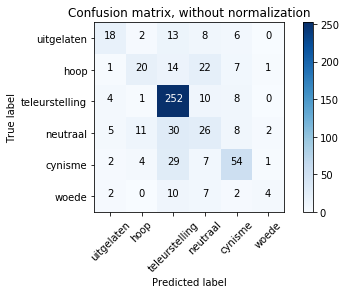

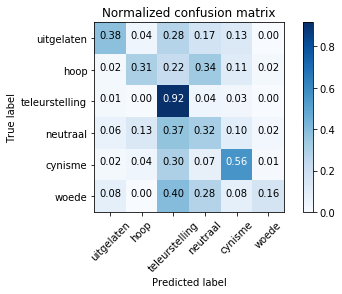

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, PredFrLR)
np.set_printoptions(precision=2)
class_names =ytrain.unique()
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Export to CSV 

In [34]:
filename = folder + "SVCSVMNl"
pickle.dump(ModelNlSVM, open(filename, 'wb'))
filename = folder + "SVCSVMFr"
pickle.dump(ModelFrSVM, open(filename, 'wb'))

In [38]:
# serialize model to JSON
model_json = ModelNlNN.to_json()
with open(folder + "modelnl.json", "w") as json_file:
    json_file.write(model_json)
model_json = ModelFrNN.to_json()
with open(folder + "modelfr.json", "w") as json_file:
    json_file.write(model_json)

In [36]:
filename = folder + "LRNl"
pickle.dump(ModelNlLR, open(filename, 'wb'))
filename = folder + "LRFr"
pickle.dump(ModelFrLR, open(filename, 'wb'))

In [37]:
AccFrNN

0.6965226554267651

In [1]:
!pip show keras

Name: Keras
Version: 2.1.6
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: c:\users\hovensa\appdata\local\continuum\anaconda3\lib\site-packages
Requires: pyyaml, scipy, numpy, h5py, six


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
